In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

def train_and_plot(currency, look_back=60, train_data_percent=0.9):

    # Load and prepare data
    df = pd.read_csv(f"data/{currency}-USD.csv")
    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.set_index('Date', inplace=True)

    # Data scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['Scaled_Close'] = scaler.fit_transform(df[['Close']])

    # Prepare training data
    train_size = int(np.ceil(len(df) * train_data_percent))

    sequences = [df['Scaled_Close'][i - look_back:i].values for i in range(look_back, len(df))]
    sequences = np.array(sequences)

    x_train, y_train = sequences[:train_size, :-1], sequences[:train_size, -1]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

    # LSTM model
    lstm_model = Sequential([
        Input(shape=(look_back - 1, 1)),
        LSTM(units=50, return_sequences=True),
        LSTM(units=50),
        Dense(1)
    ])

    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    lstm_model.save(f"models/{currency}_lstm_model.h5")

    # Prepare test data
    x_test = sequences[train_size:, :-1]
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    # Predict
    closing_price = lstm_model.predict(x_test)
    closing_price = scaler.inverse_transform(closing_price)

    # Prepare data for plotting
    valid_data = df[train_size+look_back:].copy()
    valid_index = valid_data.index
    df.loc[valid_index, 'Predictions'] = closing_price.ravel()
    valid_data = df.loc[valid_index]

    plt.figure(figsize=(16, 8))
    plt.plot(valid_data['Close'], label='Actual Close')
    plt.plot(valid_data['Predictions'], label='Predictions')
    plt.legend()
    plt.show()

1646/1646 - 65s - 39ms/step - loss: 0.0027


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 806ms/step


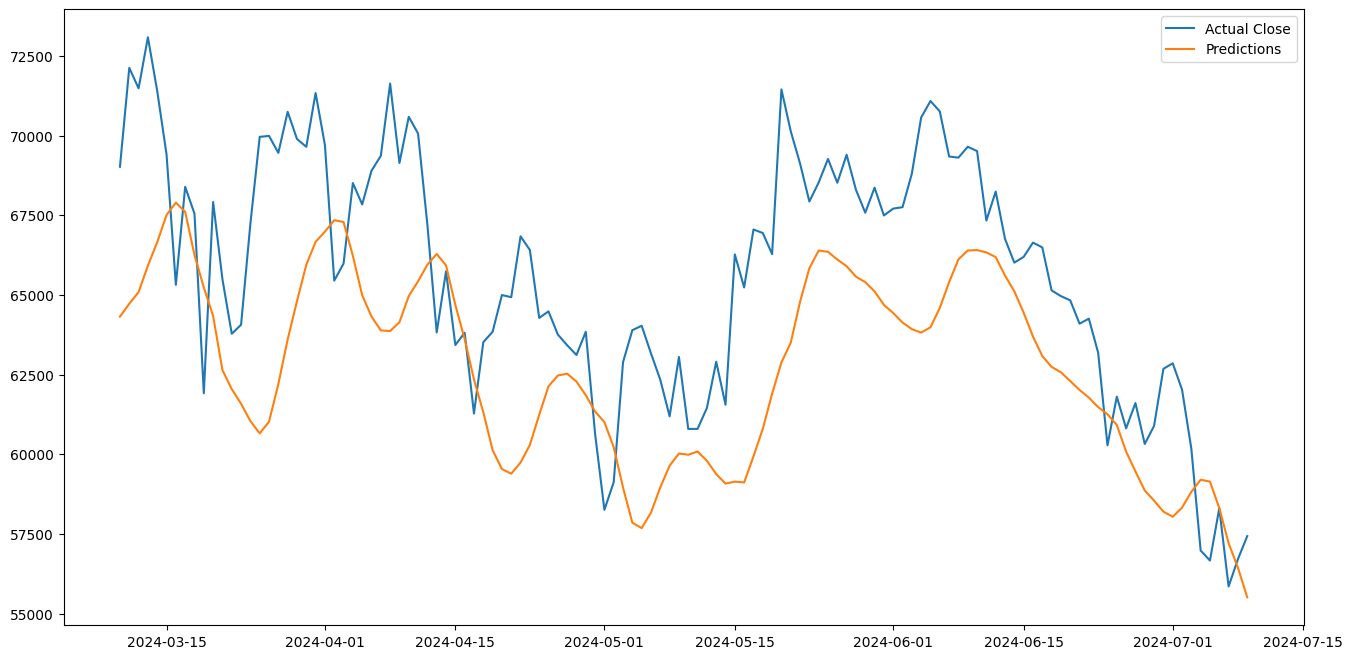

In [6]:
train_and_plot("BTC")

1646/1646 - 60s - 37ms/step - loss: 0.0023


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 641ms/step


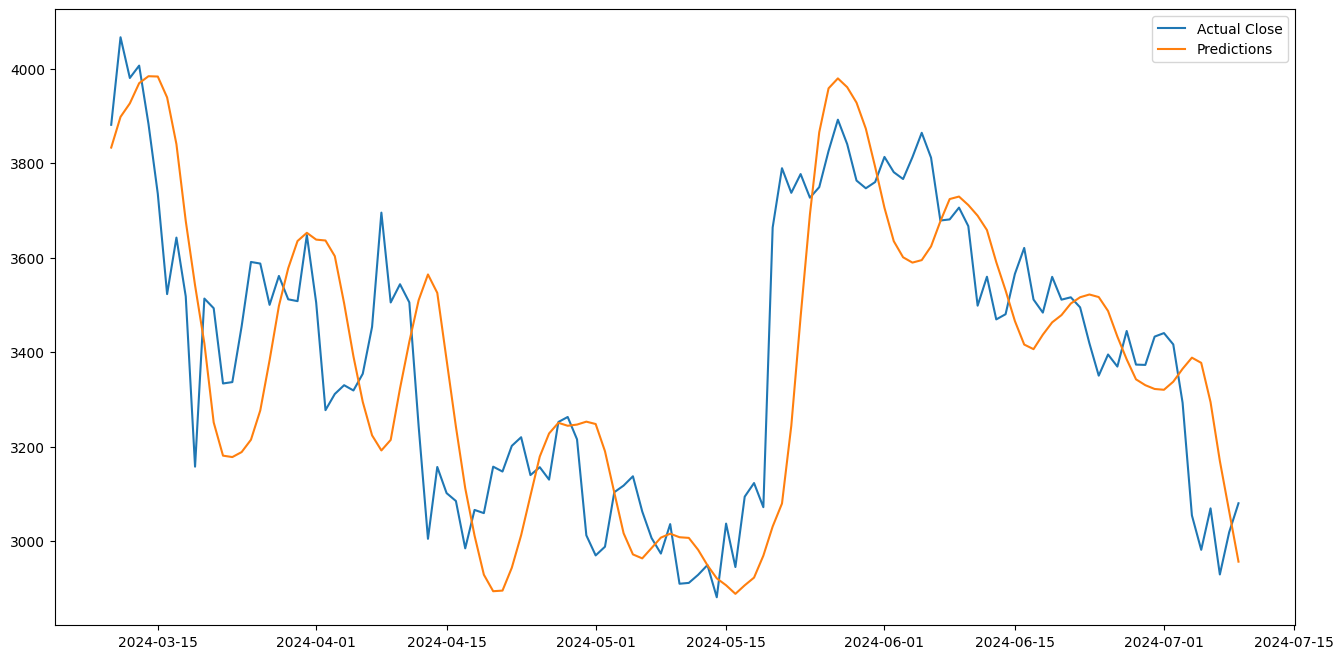

In [7]:
train_and_plot("ETH")

1646/1646 - 58s - 35ms/step - loss: 0.0017


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 769ms/step


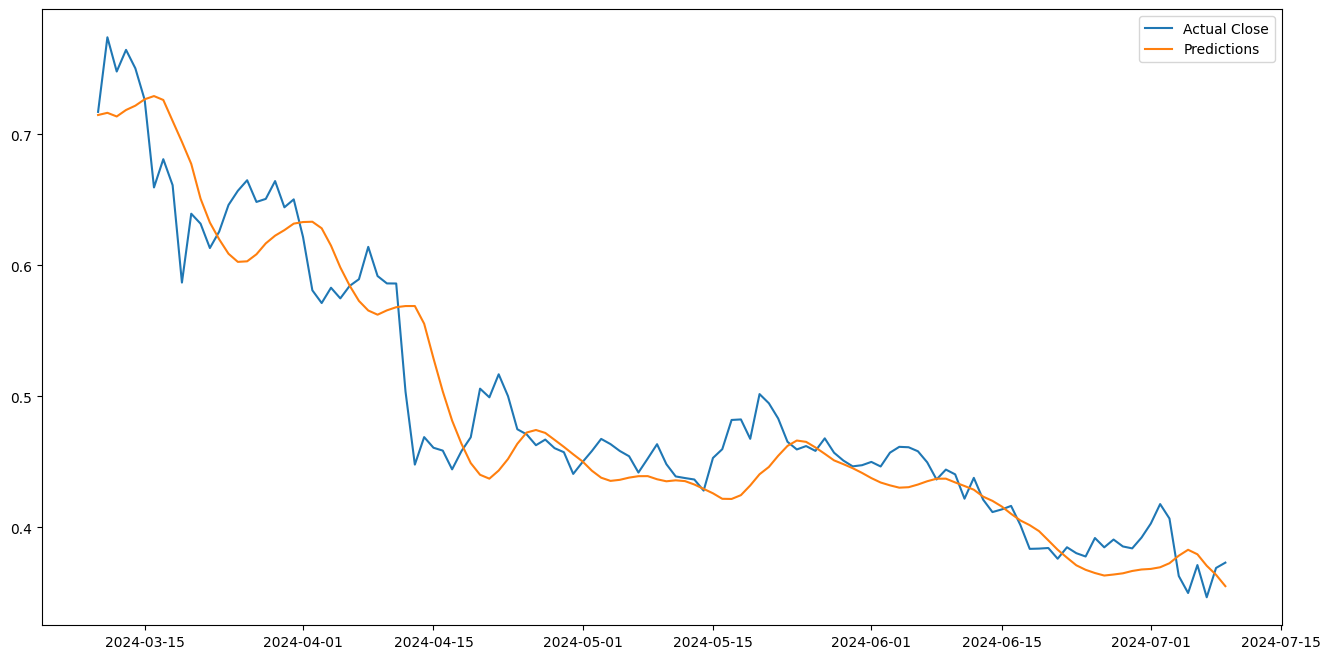

In [8]:
train_and_plot("ADA")